# Doc2Vec
We take snippets of books and **train a doc2vec model** on them.

Next, we explore **most similar documents** to 2 selected documents. Do these documents come from the same author? Do they have same genre?

In the following, we project the document vectors to 2D using **PCA** and **t-SNE** and plot them. Are documents written by the same author close to each other? Can we observe clusters based on genres?


In [1]:
import gensim # sudo pip3 install gensim
from gensim.models.doc2vec import Doc2Vec
import os
import sys
import collections
import numpy as np 
import random
import pickle
import multiprocessing
import pandas as pd
import zipfile

import logging
logging.getLogger().setLevel('INFO')

sys.path.append('..')

from src.utils import load_corpus

cores = multiprocessing.cpu_count()

RES = '../res/'
SAMPLE_BOOKS_CLEAN_FOLDER = '../res/books_clean'
TOKENIZED_DOCS_FOLDER = '../res/tokenized_docs'

SAMPLE_BOOKS_CLEAN_URL = "http://www.ms.mff.cuni.cz/~bilekja/books_sample_clean.zip"
BOOKS_ZIP_FILENAME = '../res/books_sample_clean.zip'

In [2]:
SKIP_FIRST_N_WORDS = 500
WORDS_IN_DOCUMENT = [500,2000]
SAMPLES_PER_DOCUMENT = 3

Load the Tagged Documents and pickle the whole corpus (might cause problem for big files).

In [3]:
filepath = '../res/documents_{}_{}_{}.pkl'.format(SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT, SAMPLES_PER_DOCUMENT)

if not os.path.exists(filepath):
    # create documents out of the tokens
    documents = list(load_corpus(TOKENIZED_DOCS_FOLDER, 
                                 skip_first_n_words=SKIP_FIRST_N_WORDS, 
                                 words_in_document=WORDS_IN_DOCUMENT,
                                samples_per_document=SAMPLES_PER_DOCUMENT,
                                random_seed=42))
    # save the list of documents
    pickle.dump(documents, open(filepath,'wb'))
else:
    # list of documents is already saved, load it
    documents = pickle.load(open(filepath,'rb'))
print("\nNumber of documents: {}".format(len(documents)))


Number of documents: 50023


Populate the vocabulary of the doc2vec model.

In [4]:
%%time
#model = Doc2Vec(vector_size=50, min_count=2, epochs=55, workers=-1)
#model = Doc2Vec(dm=1, dm_concat=1, vector_size=100, window=5, negative=5, hs=0, min_count=2, workers=cores)
#model = Doc2Vec(dm=0, vector_size=100, negative=5, hs=0, min_count=2, workers=cores)
## perfect in authors (.97), but bad in genres
model = Doc2Vec(dm=1, dm_mean=1, vector_size=200, window=10, negative=5, hs=0, min_count=2, workers=cores)
model.build_vocab(documents)
model.save('../res/model_{}_{}_{}.model'.format(SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT, SAMPLES_PER_DOCUMENT))

CPU times: user 23.2 s, sys: 592 ms, total: 23.8 s
Wall time: 23.9 s


Train the model (might take long time for big corpora).

In [5]:
%%time
model.train(documents, total_examples=model.corpus_count, epochs=model.epochs)
model.save('../res/model_{}_{}_{}.model'.format(SKIP_FIRST_N_WORDS, WORDS_IN_DOCUMENT, SAMPLES_PER_DOCUMENT))

CPU times: user 15min 52s, sys: 28.1 s, total: 16min 20s
Wall time: 3min 44s


As the documents are 0 indexed in Doc2Vec, we create a lookup table to keep track of document ids.

In [6]:
lookup_table = dict()
for n, (tokens, key) in enumerate(documents):
    lookup_table[key[0]] = n
    
book_ids = np.array(list(lookup_table.keys()))
book_ids_catalog = [int(b.split('_')[0]) for b in book_ids]

Representation of document vectors.

In [7]:
docvecs = np.array([model.docvecs[book_id] for book_id in book_ids])
# docvecs = np.array([model.infer_vector(documents[lookup_table[book_id]][0]) for book_id in book_ids])

### Fetch metadata catalog
- as we have multiple documents per book, we duplicate catalog entries for each document

In [8]:
from src.utils import load_catalog
metadata_catalog_0 = load_catalog()
metadata_catalog_0 = metadata_catalog_0[metadata_catalog_0.index.isin(book_ids_catalog)]

metadata_catalog = pd.DataFrame(columns=metadata_catalog_0.columns, index=book_ids)

for b in book_ids:
    metadata_catalog.loc[b] = metadata_catalog_0.loc[int(b.split('_')[0])]
print(metadata_catalog.shape)
metadata_catalog.head(5)

(50023, 10)


,author,title,downloads,formats,type,LCC,subjects,authoryearofbirth,authoryearofdeath,language
38254_0,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
38254_1,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
38254_2,"Chapman, Allen","Bart Keene's Hunting Days; or, The Darewell Ch...",7,{'application/epub+zip': 'http://www.gutenberg...,Text,{PZ},"{Camping -- Juvenile fiction, Hunting stories}",NaN,NaN,[en]
1069_0,"Zola, Émile",Four Short Stories By Emile Zola,275,{'application/x-mobipocket-ebook': 'http://www...,Text,{PQ},"{Short stories, France -- Social life and cust...",1840,1902,[en]
1069_1,"Zola, Émile",Four Short Stories By Emile Zola,275,{'application/x-mobipocket-ebook': 'http://www...,Text,{PQ},"{Short stories, France -- Social life and cust...",1840,1902,[en]


# Most similar documents and words typical for the document

In [9]:
metadata_simple = metadata_catalog[['author','title','subjects']]
pd.set_option('display.max_colwidth', -1)
n_most_sim_docs = 10

In [10]:
def similarities_table(model, catalog, doc_id=None, tokens=None, n_most_sim_docs=10):
    # if doc_id is set, use already computed vector
    if doc_id is not None:
        text = model.docvecs[doc_id]
    # if list or tuple of tokens is set, infer the vector
    elif type(tokens) in (list, tuple):
        text = model.infer_vector(tokens)
    else:
        raise Exception("doc_id or list of tokens must be specified")

    sims = np.array(model.docvecs.most_similar([text], topn=n_most_sim_docs))

    result = catalog.copy().loc[[i for i in sims[:n_most_sim_docs, 0]]]
    result['score'] = sims[:n_most_sim_docs, 1]
    result['score'] = result['score'].round(3)
    return result

## The Adventures of Sherlock Holmes

In [309]:
doc_id = '1661_0'
doc_vector = docvecs[lookup_table[doc_id]]

### Most typical words for the document

In [310]:
threshold_word_occurences = 0
min_word_length = 4
word_doc_sim = []

for word,vector in model.wv.vocab.items():
    if model.wv.vocab[word].count < threshold_word_occurences or len(word) <= min_word_length:
        continue    
    word_doc_sim.append((word, np.dot(model.wv.word_vec(word), doc_vector)))
    #q.append((word, cosine_similarity([model.wv.word_vec(word), doc_vector])[0,1]))
    #q.append((word, euclidean_distances([model.wv.word_vec(word), doc_vector])[0,1]))

word_doc_sim.sort(key=lambda x:x[1],reverse=True)
word_doc_sim[:10]

[('glanced', 37.173203),
 ('telegram', 30.825829),
 ('evidence', 30.638538),
 ('detective', 30.377247),
 ('handwriting', 30.293694),
 ('arrested', 28.61591),
 ('glancing', 28.261211),
 ('written', 28.05669),
 ('holmes', 28.01078),
 ('police', 27.796162)]

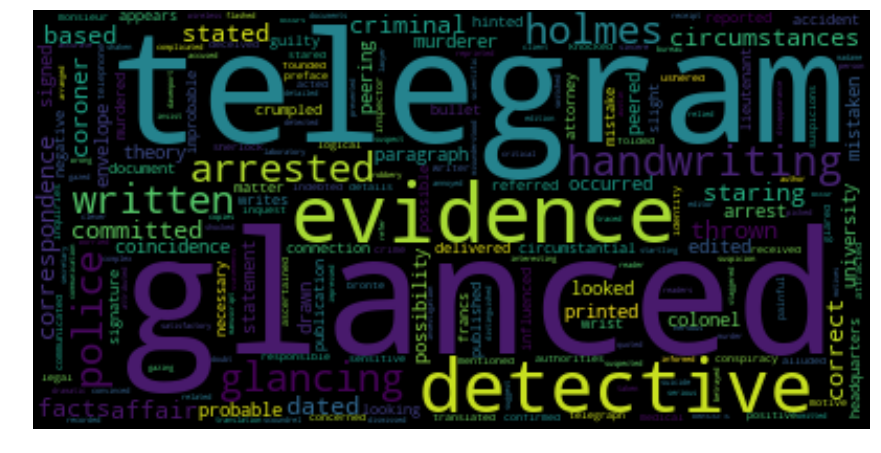

In [311]:
import wordcloud
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances

wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(word_doc_sim))

plt.figure(figsize = (15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most similar documents

In [12]:
similarities_table(model=model, catalog=metadata_simple, doc_id=doc_id, n_most_sim_docs=n_most_sim_docs)

,author,title,subjects,score
1661_0,"Doyle, Arthur Conan",The Adventures of Sherlock Holmes,"{Detective and mystery stories, English, Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction}",1.000
108_2,"Doyle, Arthur Conan",The Return of Sherlock Holmes,"{Detective and mystery stories, English, Holmes, Sherlock (Fictitious character) -- Fiction}",0.689
2343_0,"Doyle, Arthur Conan",The Adventure of Wisteria Lodge,"{Detective and mystery stories, Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction}",0.675
35205_2,"Kent, Elizabeth",Who?,"{Fiction, Detective and mystery stories, Love stories}",0.662
40997_0,"Le Queux, William",As We Forgive Them,{Mystery fiction},0.655
3070_0,"Doyle, Arthur Conan",The Hound of the Baskervilles,"{Holmes, Sherlock (Fictitious character) -- Fiction, Dogs -- Fiction, Private investigators -- England -- Fiction, Detective and mystery stories, Dartmoor (England) -- Fiction, Blessing and cursing -- Fiction}",0.648
32565_0,"Mitford, Bertram",Aletta: A Tale of the Boer Invasion,"{South African War, 1899-1902 -- Fiction, Afrikaners -- Fiction}",0.642
43492_0,"White, Fred M. (Fred Merrick)",The Five Knots,"{Jewelry theft -- Fiction, Love stories, England -- Fiction, Mystery fiction}",0.642
244_0,"Doyle, Arthur Conan",A Study in Scarlet,"{Detective and mystery stories, England -- Fiction, Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction}",0.640
2344_1,"Doyle, Arthur Conan",The Adventure of the Cardboard Box,"{Detective and mystery stories, Holmes, Sherlock (Fictitious character) -- Fiction, Private investigators -- England -- Fiction}",0.633


## Pride and Prejudice

In [312]:
doc_id = '1342_0'
doc_vector = docvecs[lookup_table[doc_id]]

### Most typical words for the document

In [313]:
threshold_word_occurences = 0
min_word_length = 4
word_doc_sim = []

for word,vector in model.wv.vocab.items():
    if model.wv.vocab[word].count < threshold_word_occurences or len(word) <= min_word_length:
        continue    
    word_doc_sim.append((word, np.dot(model.wv.word_vec(word), doc_vector)))
    #q.append((word, cosine_similarity([model.wv.word_vec(word), doc_vector])[0,1]))
    #q.append((word, euclidean_distances([model.wv.word_vec(word), doc_vector])[0,1]))

word_doc_sim.sort(key=lambda x:x[1],reverse=True)
word_doc_sim[:10]

[('madame', 39.484077),
 ('attentions', 37.370888),
 ('whiche', 36.898468),
 ('selfe', 36.270348),
 ('inform', 36.188984),
 ('marriage', 35.631344),
 ('mademoiselle', 35.558804),
 ('publication', 34.846977),
 ('sentiments', 34.424362),
 ('motives', 34.317745)]

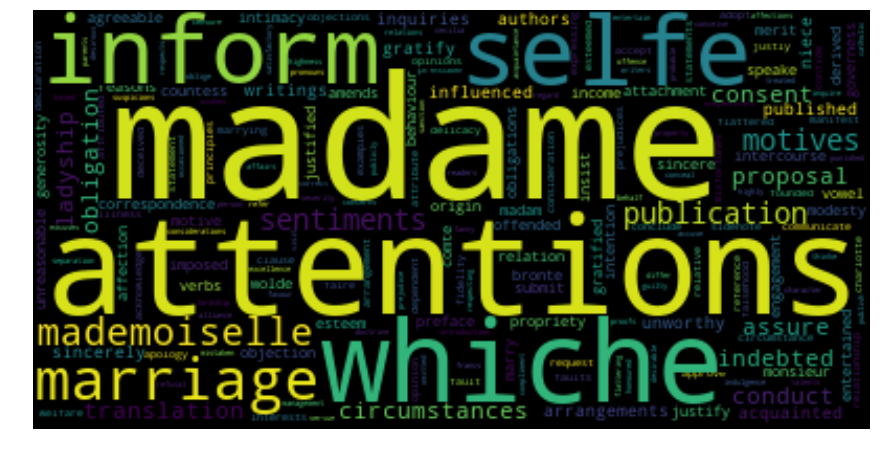

In [314]:
import wordcloud
from sklearn.metrics.pairwise import cosine_similarity,euclidean_distances

wc = wordcloud.WordCloud()
wc.generate_from_frequencies(frequencies=dict(word_doc_sim))

plt.figure(figsize = (15,15))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### Most similar documents

In [14]:
similarities_table(model=model, catalog=metadata_simple, doc_id=doc_id, n_most_sim_docs=n_most_sim_docs)

,author,title,subjects,score
1342_0,"Austen, Jane",Pride and Prejudice,"{Social classes -- Fiction, England -- Fiction, Sisters -- Fiction, Domestic fiction, Courtship -- Fiction, Love stories, Young women -- Fiction}",1.000
40406_1,"Grey, Mrs. (Elizabeth Caroline)",Mary Seaham: A Novel. Volume 2 of 3,"{Young women -- Fiction, Mate selection -- Fiction, Great Britain -- Social life and customs -- 19th century -- Fiction}",0.776
42671_0,"Austen, Jane",Pride and Prejudice,"{Social classes -- Fiction, England -- Fiction, Sisters -- Fiction, Domestic fiction, Courtship -- Fiction, Love stories, Young women -- Fiction}",0.767
42671_2,"Austen, Jane",Pride and Prejudice,"{Social classes -- Fiction, England -- Fiction, Sisters -- Fiction, Domestic fiction, Courtship -- Fiction, Love stories, Young women -- Fiction}",0.762
15991_1,"Marryat, Frederick","Japhet, in Search of a Father","{England -- Fiction, Foundlings -- Fiction}",0.758
43741_2,"Brinton, Sybil G.",Old Friends and New Fancies: An Imaginary Sequel to the Novels of Jane Austen,"{England -- Social life and customs -- 18th century -- Fiction, Courtship -- Fiction, Mate selection -- Fiction}",0.751
1342_2,"Austen, Jane",Pride and Prejudice,"{Social classes -- Fiction, England -- Fiction, Sisters -- Fiction, Domestic fiction, Courtship -- Fiction, Love stories, Young women -- Fiction}",0.751
22002_0,"Inchbald, Mrs.",A Simple Story,"{England -- Fiction, Domestic fiction, Love stories, Fathers and daughters -- Fiction, Guardian and ward -- Fiction}",0.744
24470_2,"Marryat, Frederick",Japhet in Search of a Father,"{England -- Fiction, Foundlings -- Fiction}",0.744
3341_0,"Sue, Eugène",The Wandering Jew — Volume 03,"{France -- History -- Louis Philippe, 1830-1848 -- Fiction, Wandering Jew -- Fiction, Jesuits -- Fiction, Inheritance and succession -- Fiction, Historical fiction}",0.739


# Visualization of docvecs in 2d using PCA and t-SNE

In [15]:
from matplotlib import pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline

from sklearn.decomposition.pca import PCA
from sklearn.manifold import TSNE

import itertools
markers = ['o','v','^','s','P','*','h','x','D']

## Authors

Display most common authors along with number of books in the corpus.

In [16]:
author_counts = collections.Counter(metadata_catalog.author)
author_counts.most_common(15)

[(None, 1855),
 ('Shakespeare, William', 493),
 ('Fenn, George Manville', 366),
 ('Kingston, William Henry Giles', 354),
 ('Meredith, George', 324),
 ('Various', 321),
 ('Jacobs, W. W. (William Wymark)', 318),
 ('Balzac, Honoré de', 306),
 ('Anonymous', 254),
 ('Ballantyne, R. M. (Robert Michael)', 243),
 ('Howells, William Dean', 225),
 ('James, Henry', 186),
 ('Le Queux, William', 183),
 ('Molesworth, Mrs.', 168),
 ('Harte, Bret', 162)]

Select 10 most common authors (excluding the authors *None*, *Various* and *Anonymous*).

In [17]:
n_authors = 10

selected_authors = [author for author, count in author_counts.most_common()
                           if author != None and author not in ('Various','Anonymous')]
selected_authors = selected_authors[:n_authors]
for author in selected_authors:
    print(author)

Shakespeare, William
Fenn, George Manville
Kingston, William Henry Giles
Meredith, George
Jacobs, W. W. (William Wymark)
Balzac, Honoré de
Ballantyne, R. M. (Robert Michael)
Howells, William Dean
James, Henry
Le Queux, William


Initialize variable `authors` that contains the author's name if the author is in `selected_authors`. Put 'Other' otherwise.

In [18]:
authors = metadata_catalog.loc[[b for b in book_ids]].author
authors.where(authors.isin(selected_authors), 'Other', inplace=True)

selected_author_mask = authors != 'Other'
authors_selected = reduced = authors[selected_author_mask]

### PCA

In [27]:
pca = PCA(2)
docvecs_pca = pca.fit_transform(docvecs)

In [28]:
n = len(authors.unique())
author_colors = plt.cm.Set1(np.linspace(0, 1, n))
author_markers = itertools.cycle(markers)
author_color_marker_dict = {a : (author_colors[n], next(author_markers)) for n,a in enumerate(authors.unique())}

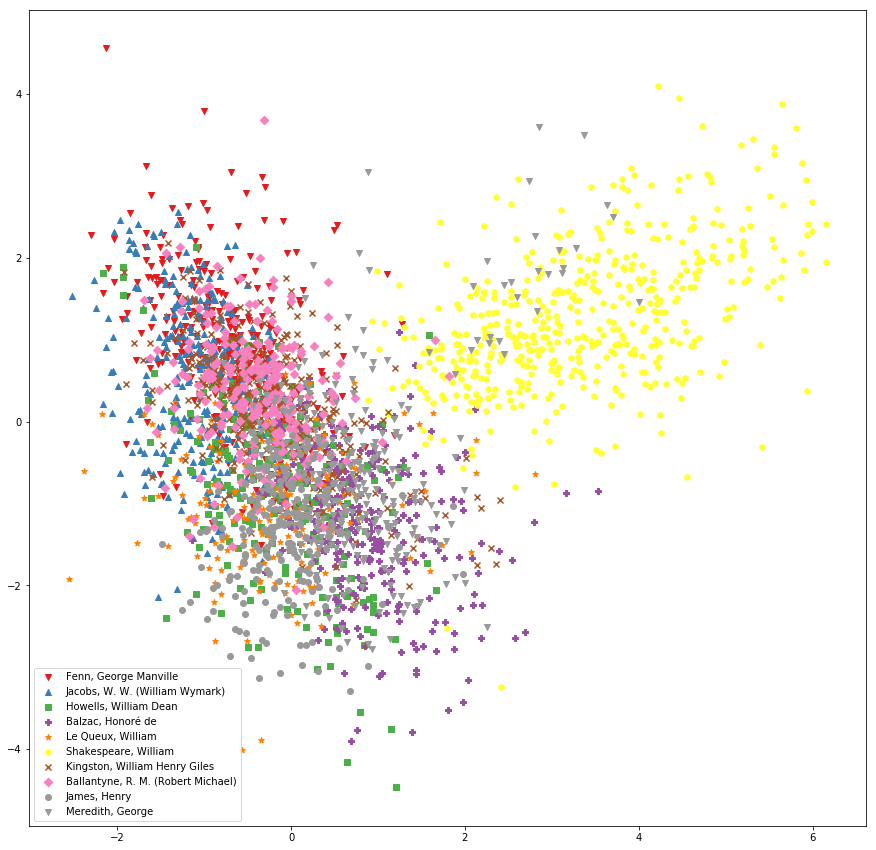

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for author,(color, marker) in author_color_marker_dict.items():
    x = docvecs_pca[authors == author, 0]
    y = docvecs_pca[authors == author, 1]
    if author == 'Other':
        continue
        alpha = 0.1
    else:
        alpha = 1
    ax.scatter(x, y, label=author, c=color, marker=marker, alpha=alpha)
    
ax.legend()

### TSNE

In [30]:
pca_n = PCA(50)
docvecs_pca_n = pca_n.fit_transform(docvecs)

In [31]:
tsne = TSNE(n_components=2)
docvecs_tsne = tsne.fit_transform(docvecs_pca_n)

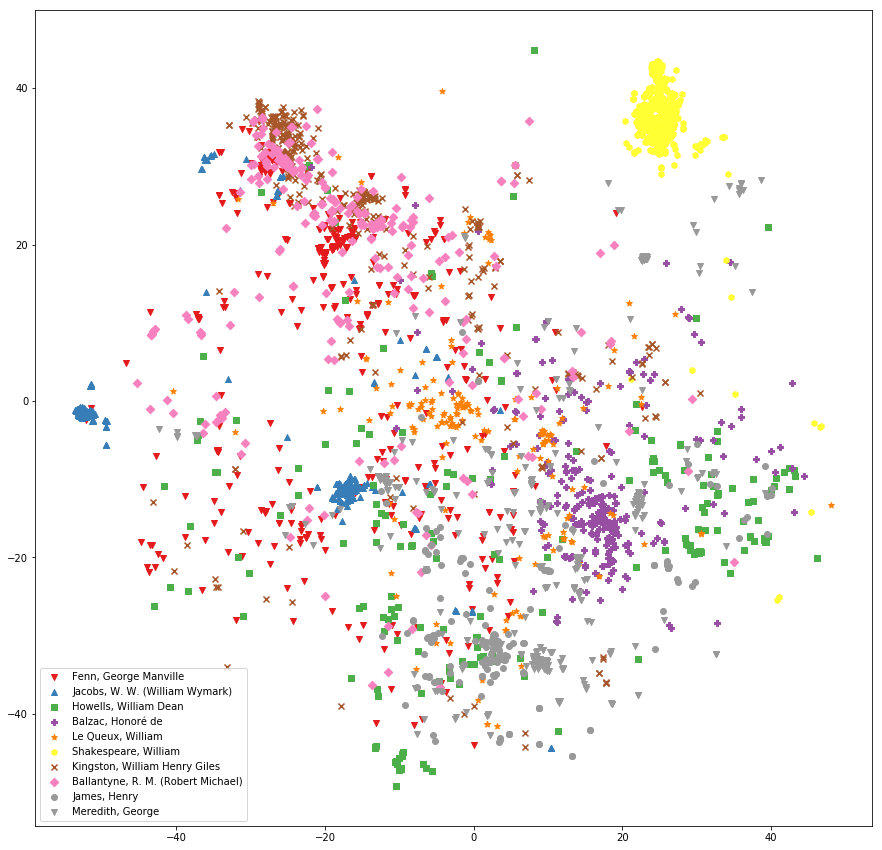

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for author,(color, marker) in author_color_marker_dict.items():
    x = docvecs_tsne[authors == author, 0]
    y = docvecs_tsne[authors == author, 1]
    if author == 'Other':
        continue
        alpha = 0.1
    else:
        alpha = 1
    ax.scatter(x, y, label=author, c=color, marker=marker, alpha=alpha)
    
ax.legend()

## Genres

In [19]:
c = [subject.lower().strip() for subjects in metadata_catalog.subjects for subject in subjects]
c2 = [simple_subject.strip() for complex_subject in c for simple_subject in complex_subject.split('--')]
#c2 = [complex_subject.split('--')[0] for complex_subject in c]
#c3 = [simple_subject.strip() for complex_subject in c2 for simple_subject in complex_subject.split(',')]
#c3 = [complex_subject.split(',')[0] for complex_subject in c2]

In [20]:
collections.Counter(c2).most_common(20)

[('fiction', 43785),
 ('juvenile fiction', 31401),
 ('social life and customs', 3743),
 ('19th century', 3687),
 ('england', 3627),
 ('history', 3563),
 ('short stories', 3431),
 ('drama', 3369),
 ('conduct of life', 3332),
 ('science fiction', 3173),
 ('translations into english', 2648),
 ('poetry', 2148),
 ('united states', 1773),
 ('great britain', 1663),
 ('adventure stories', 1548),
 ('love stories', 1440),
 ('detective and mystery stories', 1361),
 ('biography', 1260),
 ('western stories', 1134),
 ('young women', 1116)]

Chosing genres to classify on. Didn't take *fiction* and *juvenile fiction* as these might be too general.

In [21]:
selected_genres = ['short stories',
                  'science fiction',
                  'history',
                  'conduct of life',
                  'drama',
                  'poetry',
                  'detective and mystery stories',
                  'biography',
                  'western stories',
                  'children\'s stories']

Documents having exactly one genre out of `specified genres` are given that genre. Documents having more than one of genres in `selected genres` or none of them are set to *other* and will be not used for classifying.

In [22]:
def modify_genres(genre_set):
    if len(genre_set) == 0:
        return set()
    result_set = set()
    for s in genre_set:
        result_set = result_set.union(set([x.lower().strip() for x in s.split('--')]))
    return result_set

metadata_catalog['modified_genres'] = metadata_catalog.subjects.apply(modify_genres)

genres = metadata_catalog['modified_genres'].apply(
    lambda x: list(x.intersection(selected_genres))[0]
      if len(x.intersection(selected_genres))==1 else 'other')

selected_genre_mask = genres != 'other'
genres_selected = authors[selected_genre_mask]
genres.value_counts()

other                            35361
history                          2663 
conduct of life                  1937 
short stories                    1785 
poetry                           1744 
science fiction                  1707 
detective and mystery stories    1304 
drama                            1096 
western stories                  1062 
biography                        843  
children's stories               521  
Name: modified_genres, dtype: int64

In [23]:
NUM_COLORS = len(genres.unique())+1

cm = plt.get_cmap('Set1')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

### PCA

In [42]:
n = len(selected_genres)
n_samples_per_genre = 100

genre_colors = plt.cm.Set1(np.linspace(0, 1, n))
genre_markers = itertools.cycle(markers)
print(genre_markers)
genre_color_marker_dict = {g : (genre_colors[n], next(genre_markers)) for n,g in enumerate(selected_genres)}

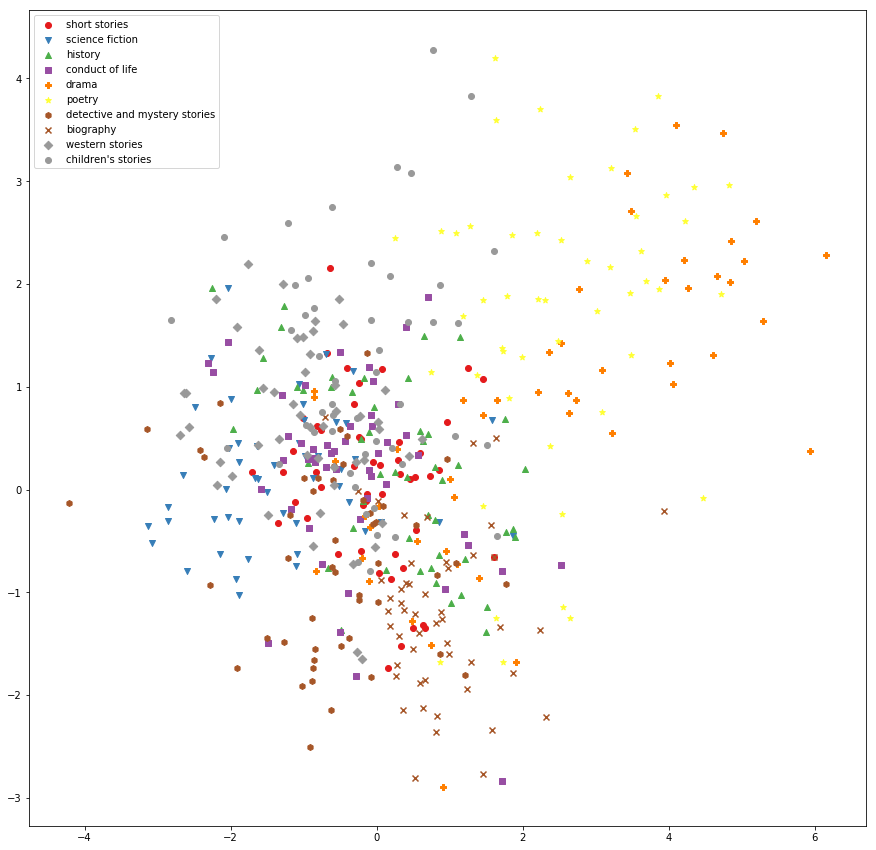

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for genre,(color, marker) in genre_color_marker_dict.items():
    x = docvecs_pca[genres == genre, 0][:n_samples_per_genre]
    y = docvecs_pca[genres == genre, 1][:n_samples_per_genre]
    alpha = 1
    ax.scatter(x, y, label=genre, c=color, marker=marker, alpha=alpha)
    
ax.legend()

### TSNE

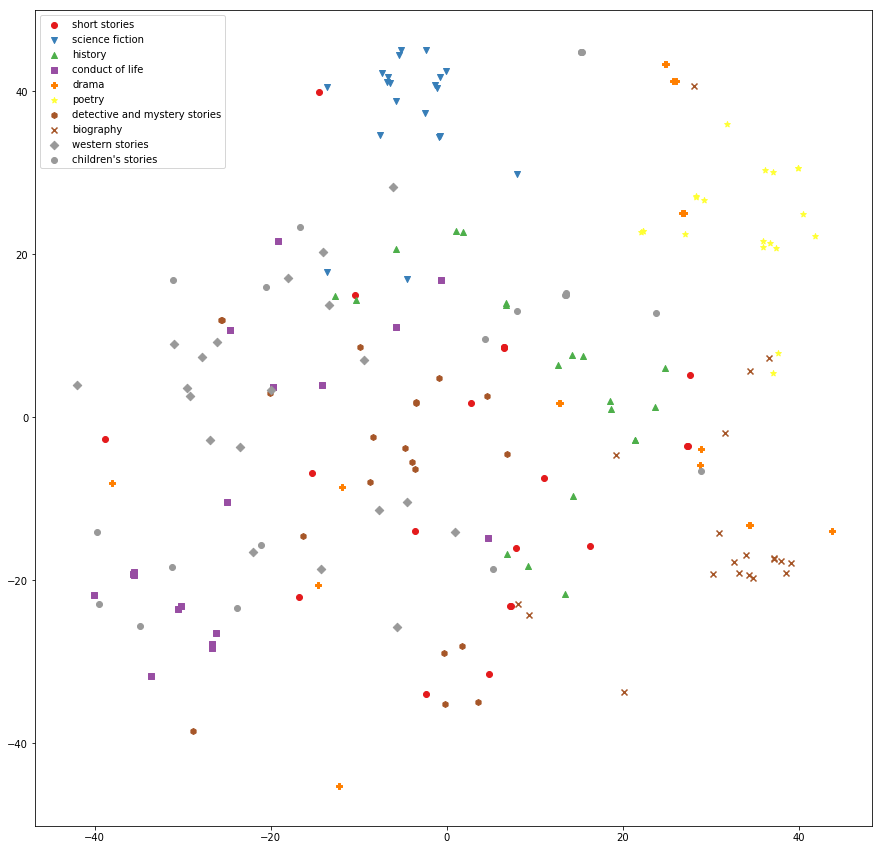

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

for genre,(color, marker) in genre_color_marker_dict.items():
    x = docvecs_tsne[genres == genre, 0][:n_samples_per_genre]
    y = docvecs_tsne[genres == genre, 1][:n_samples_per_genre]
    alpha = 1
    ax.scatter(x, y, label=genre, c=color, marker=marker, alpha=alpha)
    
ax.legend()

# CLASSIFIERS

In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

In [35]:
classifiers = {'Logistic Regression': LogisticRegression(class_weight='balanced'),
              'Random Forest': RandomForestClassifier(n_estimators=500, 
                                     class_weight='balanced', 
                                     min_samples_leaf=10, 
                                     max_features='sqrt', 
                                     max_depth=7),
              'Gaussian Naive Bayes': GaussianNB(),
              'KNN 15' : KNeighborsClassifier(15),
              'KNN 11 distance weights' : KNeighborsClassifier(11, weights='distance'),
              'KNN 9' :KNeighborsClassifier(9),
              'SVM C=5': SVC(class_weight='balanced', C=5),
              'SVM C=20': SVC(class_weight='balanced', C=20),
              'SVM C=80': SVC(class_weight='balanced', C=80)}

## Author

In [36]:
X_train, X_test, y_train, y_test, ids_train, ids_test = \
    train_test_split(docvecs[selected_author_mask], authors[selected_author_mask], book_ids[selected_author_mask])
    
labels = sorted(authors[selected_author_mask].unique())

In [37]:
author_results = pd.DataFrame(columns=['f1-macro on train','f1-macro on test','accuracy on train','accuracy on test'])

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    f1_score_macro_train = f1_score(y_train, y_pred_train, average='macro')
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    f1_score_macro_test = f1_score(y_test, y_pred_test, average='macro')
    accuracy_score_test = accuracy_score(y_test, y_pred_test)
    author_results.loc[clf_name,:] = [f1_score_macro_train, f1_score_macro_test, accuracy_score_train, accuracy_score_test]

author_results.sort_values(['f1-macro on test'], ascending=False, inplace=True)
author_results

,f1-macro on train,f1-macro on test,accuracy on train,accuracy on test
Logistic Regression,0.991845,0.952519,0.992438,0.956
SVM C=5,0.982033,0.928007,0.983986,0.938667
SVM C=20,0.998595,0.927083,0.998665,0.937333
SVM C=80,1,0.919879,1,0.930667
Gaussian Naive Bayes,0.854358,0.83639,0.865658,0.853333
Random Forest,0.963817,0.82784,0.965302,0.853333
KNN 15,0.856639,0.817725,0.873221,0.84
KNN 11 distance weights,1,0.816402,1,0.841333
KNN 9,0.872761,0.806982,0.884786,0.837333


Select the best model

In [38]:
clf = classifiers[author_results.index[0]]
clf

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Show confusion matrix for the test set.

In [39]:
pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), columns=labels, index=labels)

,"Ballantyne, R. M. (Robert Michael)","Balzac, Honoré de","Fenn, George Manville","Howells, William Dean","Jacobs, W. W. (William Wymark)","James, Henry","Kingston, William Henry Giles","Le Queux, William","Meredith, George","Shakespeare, William"
"Ballantyne, R. M. (Robert Michael)",59,1,1,0,0,0,4,0,0,0
"Balzac, Honoré de",0,69,0,0,0,0,1,0,0,0
"Fenn, George Manville",1,0,89,1,0,0,1,1,0,0
"Howells, William Dean",0,1,1,51,1,1,0,1,0,0
"Jacobs, W. W. (William Wymark)",1,0,0,0,71,0,0,0,0,0
"James, Henry",0,0,0,2,0,41,0,0,0,0
"Kingston, William Henry Giles",3,2,2,0,1,0,86,0,0,0
"Le Queux, William",1,0,1,0,0,0,0,36,0,0
"Meredith, George",0,1,0,0,0,0,0,0,92,0
"Shakespeare, William",0,0,0,1,0,0,1,0,1,123


## Genre

In [271]:
X_train, X_test, y_train, y_test, ids_train, ids_test = \
    train_test_split(docvecs[selected_genre_mask], genres[selected_genre_mask], book_ids[selected_genre_mask])

labels = sorted(genres[selected_genre_mask].unique())

In [41]:
genre_results = pd.DataFrame(columns=['f1-macro on train','f1-macro on test','accuracy on train','accuracy on test'])

for clf_name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    f1_score_macro_train = f1_score(y_train, y_pred_train, average='macro')
    accuracy_score_train = accuracy_score(y_train, y_pred_train)
    f1_score_macro_test = f1_score(y_test, y_pred_test, average='macro')
    accuracy_score_test = accuracy_score(y_test, y_pred_test)
    genre_results.loc[clf_name,:] = [f1_score_macro_train, f1_score_macro_test, accuracy_score_train, accuracy_score_test]

genre_results.sort_values(['f1-macro on test'], ascending=False, inplace=True)
genre_results

,f1-macro on train,f1-macro on test,accuracy on train,accuracy on test
SVM C=20,0.81687,0.665869,0.815296,0.676214
SVM C=80,0.925025,0.664496,0.920789,0.678123
SVM C=5,0.74086,0.663002,0.742907,0.671849
Logistic Regression,0.684558,0.640448,0.692434,0.656847
KNN 11 distance weights,1,0.634832,1,0.658483
KNN 9,0.702137,0.611911,0.716806,0.633388
KNN 15,0.66812,0.598845,0.692615,0.634206
Gaussian Naive Bayes,0.578801,0.571339,0.586577,0.58156
Random Forest,0.635825,0.537218,0.649691,0.564103


Select the best model

In [42]:
clf = classifiers[author_results.index[0]]
clf

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Show confusion matrix for the test set.

In [43]:
pd.DataFrame(confusion_matrix(y_test, clf.predict(X_test)), columns=labels, index=labels)

,biography,children's stories,conduct of life,detective and mystery stories,drama,history,poetry,science fiction,short stories,western stories
biography,151,2,4,2,5,19,10,6,11,1
children's stories,3,56,44,1,2,10,4,2,7,0
conduct of life,6,62,267,35,5,35,8,4,30,24
detective and mystery stories,5,4,21,216,2,26,1,15,35,18
drama,15,1,1,2,243,1,15,0,3,1
history,30,18,61,33,13,400,13,9,41,34
poetry,27,4,4,0,18,10,357,6,9,2
science fiction,3,3,4,13,3,15,1,360,26,6
short stories,24,16,34,37,9,56,13,33,156,39
western stories,3,4,10,18,1,28,0,5,14,202


### Using polynomial features for logistic regression

In [269]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)

In [272]:
print(X_train.shape)
X_train = poly.fit_transform(X_train)
print(X_train.shape)
X_test = poly.transform(X_test)

(10996, 200)
(10996, 20301)


In [275]:
model2 = LogisticRegression()
model2.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [315]:
y_pred_train = model2.predict(X_train)
y_pred_test = model2.predict(X_test)
print(f1_score(y_train, y_pred_train, average='macro'))
print(accuracy_score(y_train, y_pred_train))
print(f1_score(y_test, y_pred_test, average='macro'))
print(accuracy_score(y_test, y_pred_test))

1.0
1.0
0.6876835313791855
0.7103109656301145


# SUMMARY:
- The **most similar documents** are usually documents written by the **same author** or having **similar genre**.
- We can observe **documents by one author** being **close to each other** in 2D when using either PCA or t-SNE dimensionality reduction
- Same genres also appear close together, however not as strong as for the authors
- Good classifier for 10 author and 10 genre classes on **word2vec representaion** turned out to be **One vs One Logistic Regression** and **SVM**:
  - **author classifier is close to perfect**
  - **genre classifier** is performing good but still has **minor room for improvement**
  - using **polynomial features** (deg 2) further **improves** the Logistic regression classifier on genres **by 5 %**